# CSC-30043 Data Mining Assessment
## Group 5
## Loan Default Prediction - Full Pipeline

This notebook contains all the code for our data mining coursework. For our assignment, we were asked to predict whether bank loans will be 'Charged Off' (defaulted) or 'Fully Paid' using classification algorithms.




---
## Section 1: Introduction (Slides 1-5)

The business problem: banks need to assess risk before approving loans. Some borrowers default ('Charged Off') which can lead to financial losses, while others repay successfully ('Fully Paid'). 

Looking at our dataset, it's clear to see this split: 77% of loands are fully paid whilst 23% defaulted. This 23% represents real money lost; therefore, our task was to build a classification model to predict which loands are likely to default before they're approved.

For our methodology, we followed the KDD process: This gives us a clear and structured pipeline to follow

1. Selection - starting with raw loan data
2. Preprocessing - cleaning missing vlaues, handling outliers, removing duplicates
3. Transformation - encoding categorical features and scaling numerical ones
4. Data mining - applying classification algorithms
5. Evaluation - testing performance with accuracy, f1-score, confusion matrix

This framework is standard in data mining research and ensures that we're not just throwing algorithms at the data randomly, but that there is a process behind eveyrhting we're doing.

In [8]:
# Import all the libraries we'll need
# doing this at the start so we dont have to keep importing stuff later

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (confusion_matrix, accuracy_score,  precision_score, recall_score, f1_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported!")

All libraries imported!


In [9]:
# Load the datasets
# make sure these CSV files are in the same folder as this notebook

train = pd.read_csv('Training Data.csv')
test = pd.read_csv('Test data.csv')

print(f"training data: {train.shape[0]:,} rows, {train.shape[1]} columns")
print(f"test data: {test.shape[0]:,} rows, {test.shape[1]} columns")

training data: 100,514 rows, 19 columns
test data: 10,353 rows, 18 columns


In [10]:
# Quick look at the target variable distribution
# this is what we saw on Slide 2 - the pie chart

target = train['Loan Status'].value_counts()
print("Target Distribution:")
print(f"fully Paid: {target['Fully Paid']:,} ({target['Fully Paid']/len(train)*100:.1f}%)")
print(f"charged Off: {target['Charged Off']:,} ({target['Charged Off']/len(train)*100:.1f}%)")
print(f"imbalance ratio: {target['Fully Paid']/target['Charged Off']:.1f}:1")

Target Distribution:
fully Paid: 77,361 (77.0%)
charged Off: 22,639 (22.5%)
imbalance ratio: 3.4:1


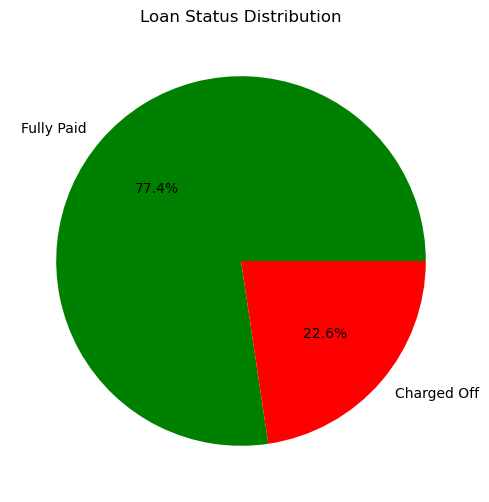

In [11]:
# load fresh data for this chart
raw_train = pd.read_csv('Training Data.csv')
counts = raw_train['Loan Status'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(counts.values, 
        labels=counts.index,
        autopct='%1.1f%%',
        colors=['green', 'red'])
plt.title('Loan Status Distribution')
plt.show()

In [12]:
# Missing values analysis - Slide 3/4
# this is important for showing why preprocessing is needed

missing_pct = (train.isnull().sum() / len(train)) * 100
missing_pct = missing_pct.sort_values(ascending=True)

print("Key Missing Values:")
print(f"months since last delinquent: {missing_pct['Months since last delinquent']:.1f}% REMEMBER TO drop in part 3 m")
print(f"Credit Score: {missing_pct['Credit Score']:.1f}% (will impute with median)")
print(f"Annual Income: {missing_pct['Annual Income']:.1f}% (will impute with median)")
print(f"Years in current job: {missing_pct['Years in current job']:.1f}% (categorical - will impute with mode)")

Key Missing Values:
months since last delinquent: 53.4% REMEMBER TO drop in part 3 m
Credit Score: 19.6% (will impute with median)
Annual Income: 19.6% (will impute with median)
Years in current job: 4.7% (categorical - will impute with mode)


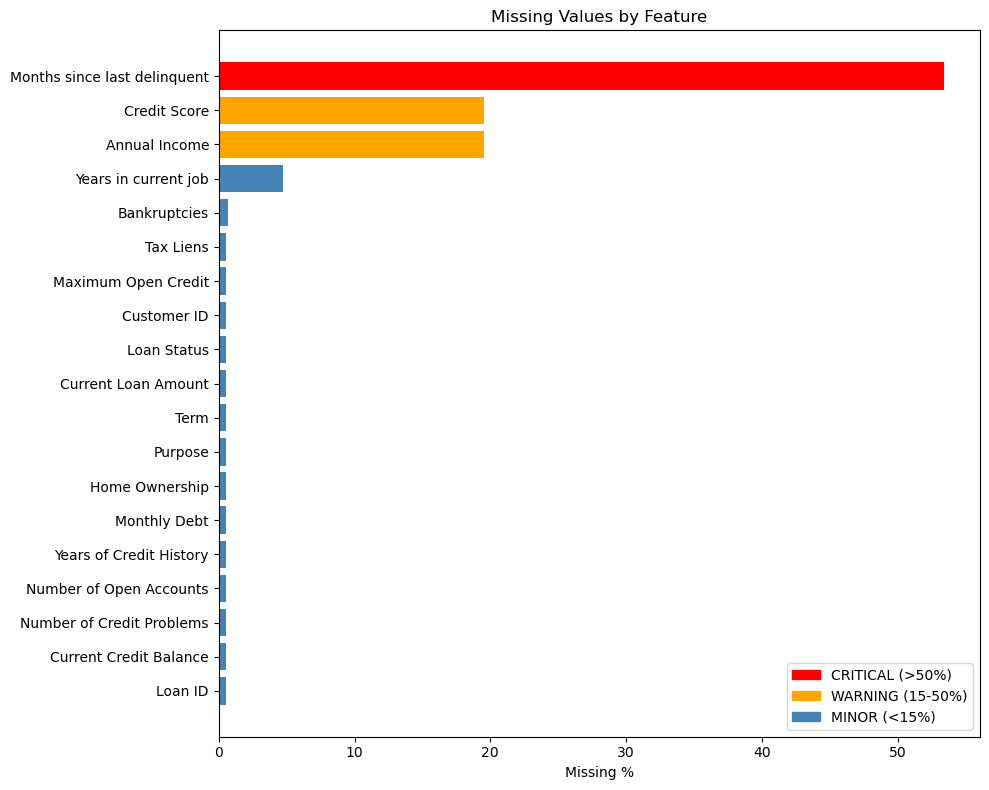

In [13]:
import matplotlib.patches as mpatches
# missing values chart
# missing value analysis - slide 4

raw_train = pd.read_csv('Training Data.csv')
missing_pct = (raw_train.isnull().sum() / len(raw_train)) * 100
missing_pct = missing_pct.sort_values(ascending=True)

# colors based on severity
colors = []
for pct in missing_pct.values:
    if pct > 50:
        colors.append('red')
    elif pct > 15:
        colors.append('orange')
    else:
        colors.append('steelblue')

plt.figure(figsize=(10, 8))
plt.barh(missing_pct.index, missing_pct.values, color=colors)
plt.xlabel('Missing %')
plt.title('Missing Values by Feature')

# add legend
red_patch = mpatches.Patch(color='red', label="CRITICAL (>50%)")
orange_patch = mpatches.Patch(color='orange', label="WARNING (15-50%)")
blue_patch = mpatches.Patch(color='steelblue', label="MINOR (<15%)")
plt.legend(handles=[red_patch, orange_patch, blue_patch], loc='lower right')

plt.tight_layout()
plt.show()

---
## Section 2: Literature Review (Slides 7-9)

Before building our model, we reviewed existing research on loan default prediction. This is very importance since we don't just want to pick an algorithm randomly - we want to see what's already been proven to work on similar problems

The literature we found was that ensemble methods (e.g. algorithms that combine multiple models) outperform single classifiers for this type of problem. Havign discussed in out presentation - Interpretability is very importance and XGBoost provides feature importance which helps with this.

Slide 7

### Why We Chose XGBoost (Slide 9)

Due to difficult decisions and analysis, we selected XGBoost as our main algorithm mainly due to:

1. Highest Accuracy - 75.19% on our data vs 73.74% for Decision Tree
2. Strong F1-Score - 85.56% (essentially tied with RF's 85.61%)
4. Handles Imbalanced Data - has built-in handling for our 77/23 class split via scale_pos_weight
5. Gradient Boosting - learns from previous errors iteratively
6. Feature Importance - still provides interpretable feature rankings (important for finance)

### Why Traditional Models Underperform (Slide 8)

- Logistic Regression assumes linear relationships: these are  unreliable for complex financial behaviour
- SVM struggles with large feature interactions unless kernelised
- Decision Trees can tend to overfit with high variance

However: 

- Ensemble models (RF, XGBoost) have lower variance and bias due to boosting/bagging

We we're very close to picking Random Forest, but in the end switched to XGBoost just for the points listed below. We looked at some papers and analysed them in our literature review.

---
## Section 3: Data Preprocessing (Slide 10)

Following the KDD process, we need to clean and prepare our data before applying any algorithms. The assessment brief specifically asks us to document:
- How missing values are handled
- Scaling and encoding
- Changes to dataset dimensions



In [14]:
# Step 1: Remove duplicates
# pretty important since we dont want the same loan appearing multiple times

before = len(train)
train = train.drop_duplicates()
after = len(train)

print(f"Duplicates removed: {before - after:,}")
print(f"Rows remaining: {after:,}")

Duplicates removed: 10,728
Rows remaining: 89,786


In [15]:
train['Current Loan Amount'].describe()

count    8.978500e+04
mean     1.306089e+07
std      3.329556e+07
min      1.080200e+04
25%      1.802680e+05
50%      3.138740e+05
75%      5.323780e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [16]:
# Step 2: Save test IDs + drop ID columns
# we need to keep the loan IDs for later but they're not useful features, especially not at the moment

if 'Loan ID' in test.columns:
    test_ids = test['Loan ID'].copy()
    print("Saved test IDs for final output")
else:
    test_ids = pd.Series(range(len(test)))
    print("Using index as test IDs")

# drop ID columns as they don't help with prediction
cols_to_drop = ['Loan ID', 'Customer ID']
train = train.drop(columns=[c for c in cols_to_drop if c in train.columns]) #drop from train
test = test.drop(columns=[c for c in cols_to_drop if c in test.columns]) #drop from test

print(f"Train columns: {len(train.columns)} | Test columns: {len(test.columns)}")

Saved test IDs for final output
Train columns: 17 | Test columns: 16


### Outlier Detection

From our EDA, we found two issues:

1. **Current Loan Amount** - max value is 100 million (1.0e+08), we decided that this is clearly a placeholder, not a real loan amount. 

2. **Credit Score** - some values are above 850, which is impossible as FICO scores max out at 850. so most likely, these could be be missing a decimal point (e.g., 7340 should be 734.0).

Before we proceed, we need to fix both

In [17]:
# Step 3: Fix outliers
# found two main issues in the data during EDA

# Current Loan Amount has placeholder value 99999999 (obviously this is not a real loan amount)
median_loan = train[train['Current Loan Amount'] < 10000000]['Current Loan Amount'].median()
train['Current Loan Amount'] = train['Current Loan Amount'].replace(10000000, median_loan)
test['Current Loan Amount'] = test['Current Loan Amount'].replace(10000000, median_loan)

# Credit Score > 850 is impossible (max FICO is 850)
# these look like they forgot the decimal point, so I beleive it would be safe to divide by 10
train.loc[train['Credit Score'] > 850, 'Credit Score'] = train.loc[train['Credit Score'] > 850, 'Credit Score'] / 10
test.loc[test['Credit Score'] > 850, 'Credit Score'] = test.loc[test['Credit Score'] > 850, 'Credit Score'] / 10
# michael found that FICO credit scores have a fixed range of 300-850. Any value above 850 is impossible so they must be data entry errors

print("Fixed outliers in Current Loan Amount and Credit Score")

Fixed outliers in Current Loan Amount and Credit Score


In [18]:
# Step 4: Handle missing values

# first drop any rows where target is missing (cant train on those)
train = train.dropna(subset=['Loan Status'])

# drop 'Months since last delinquent' - over 53% missing is too much to impute reliably
if 'Months since last delinquent' in train.columns:
    train = train.drop(columns=['Months since last delinquent'])
if 'Months since last delinquent' in test.columns:
    test = test.drop(columns=['Months since last delinquent'])
print("Dropped 'Months since last delinquent 53% missing)") #FIFTY THREE PERCENT, WE SAID WE'D DROP EARLIER!

# next, fil numerical columns with median
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
for col in numerical_cols: #loop through numericals 
    median_val = train[col].median()
    train[col] = train[col].fillna(median_val)
    if col in test.columns:
        test[col] = test[col].fillna(median_val)

# finalyl we need tofill categorical columns with mode
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
if 'Loan Status' in categorical_cols:
    categorical_cols.remove('Loan Status')

for col in categorical_cols: #loop through cateforialcs
    mode_val = train[col].mode()[0]
    train[col] = train[col].fillna(mode_val)
    if col in test.columns:
        test[col] = test[col].fillna(mode_val)

print(f"Missing values after imputation: Train={train.isnull().sum().sum()}, Test={test.isnull().sum().sum()}")

#nice code

Dropped 'Months since last delinquent 53% missing)
Missing values after imputation: Train=0, Test=0


In [19]:
# Step 5: Prepare features and target

y_full = train['Loan Status']
X_train_full = train.drop(columns=['Loan Status'])
X_test_final = test.copy() # get a copy of our rest data

# encode target variable
# Charged Off = 0, Fully Paid = 1
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y_full)
#clean encoding, making sure everything is normalised

print(f"Target encoding: {le_target.classes_}")
print(f"Class distribution: Fully Paid={sum(y_encoded==1):,}, Charged Off={sum(y_encoded==0):,}") #stack overflow

#VERY IMPORTANT NOTE, TEST DATA DOESNT HAVE A TARGET VARIABLE (LOAN STATUS), TEST DATA HAS NO LOAN STATUS AS WE'RE PREDICTING IT
#IF THERE WAS A TARGET IN TEST,

Target encoding: ['Charged Off' 'Fully Paid']
Class distribution: Fully Paid=67,146, Charged Off=22,639


Sangeeta meeting (10/12/25): Sangeeta questioned us about the reason as to why test data doesn't have a target variable.

VERY IMPORTANT NOTE, Test data doesn't have a target variable (LOAN STATUS), Test data has no loan status since we're predicting it.

If there was a target in the test value, this wouldn't be a prediction task.


In [20]:
# Step 6: Encode categorical features

# Here, we are label encoding anything with the phrase 'Term' ( since it only has 2 values: Short Term, Long Term)
le_term = LabelEncoder()
X_train_full['Term'] = le_term.fit_transform(X_train_full['Term'].astype(str))
X_test_final['Term'] = le_term.transform(X_test_final['Term'].astype(str))

#done

# One-hot encode the rest (Purpose, Home Ownership, Years in current job)
onehot_cols = ['Home Ownership', 'Purpose', 'Years in current job']
onehot_cols = [c for c in onehot_cols if c in X_train_full.columns] # same technique as above

#ravel works too? anyways, here we're just making sure the datasets colums have the onehot columns
X_train_full = pd.get_dummies(X_train_full, columns=onehot_cols, drop_first=True)
X_test_final = pd.get_dummies(X_test_final, columns=onehot_cols, drop_first=True)

# make sure train and test have the same columns - need to apply a few operations to get this exact
X_train_full, X_test_final = X_train_full.align(X_test_final, join='left', axis=1, fill_value=0)

print(f"Features after encoding: {X_train_full.shape[1]}")

Features after encoding: 40


In [21]:
# Step 7: Scale numerical features
# Here, we are using Z-score standardization (where mean=0, std=1)
# This is important as features have different ranges e.g. Annual Income (thousands) vs Bankruptcies (0-5)
# Without scaling it would be mostly that  larger values would dominate the model


scale_cols = ['Current Loan Amount', 'Credit Score', 'Annual Income', 
              'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts',
              'Number of Credit Problems', 'Current Credit Balance', 
              'Maximum Open Credit', 'Bankruptcies', 'Tax Liens']
scale_cols = [c for c in scale_cols if c in X_train_full.columns] #same technique as before 

scaler = StandardScaler()
X_train_full[scale_cols] = scaler.fit_transform(X_train_full[scale_cols])
X_test_final[scale_cols] = scaler.transform(X_test_final[scale_cols])

print(f"Scaled {len(scale_cols)} numerical features")

Scaled 11 numerical features


We use fit_transform on training data to learn the mean and standard deviation, then only transform on test data using those same values. We do this as it prevents data leakage and so we don't let the model see test data statistics.

In [22]:
# Step 8: Train-validation split
# assessment says 80% train, 20% validation - THIS IS IN THE BRIEF. BEING SPECIFIC!
# using stratified split to maintain class balance

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded  # important for imbalanced data
)

print(f"Training set: {len(X_train):,} samples (80%)")
print(f"Validation set: {len(X_val):,} samples (20%)")

Training set: 71,828 samples (80%)
Validation set: 17,957 samples (20%)


# PREPROCESSING SUMMARY

 - Removed 10,728 duplicates
 - Dropped ID columns: 'Loan ID', 'Customer ID'
 - Fixed credit score outliers (>850 to /10)
 - Dropped 'Months since last delinquent' (53% missing, discussed above)
 - Imputed missing values (median for nums, mode for cats)
 - Encoded 'Term' (label), and one-hot encoded 'Purpose', 'Home', 'Job'
 - Scaled numeric features using z-score (11 features)
 - Stratified 80/20 train/test split


---
## Section 4: Model Training and Results (Covering Slides 11-16)

Now we train and compare 4 different classification algorithms:
1. Logistic Regression - baseline linear model
2. Decision Tree - simple rule-based (from lectures)
3. Random Forest - ensemble of trees (bagging)
4. XGBoost - gradient boosted trees

We'll evaluate using accuracy, precision, recall, and F1-score. The confusion matrix will show us the breakdown of true/false positives and negatives.


In [23]:
# Train all 4 models and store results

print("TRAINING 4 MODELS")

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=20, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGBoost': GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...") #keep training like a loading until its done (...)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    results[name] = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'model': model,
        'predictions': y_pred
    }
    print(f"  Done - Accuracy: {results[name]['accuracy']*100:.2f}%")

TRAINING 4 MODELS
Training Logistic Regression...
  Done - Accuracy: 75.00%
Training Decision Tree...
  Done - Accuracy: 73.80%
Training Random Forest...
  Done - Accuracy: 74.83%
Training XGBoost...
  Done - Accuracy: 75.13%


In [24]:
# Print comparison table
print("\n" + "="*75)
print("4-MODEL COMPARISON RESULTS (for Slide 11)")
print("="*75)
print(f"{'Algorithm':<22} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*75)

#generates a nice mock table with '=' and '-' just to format our resutls. this is a new way or formatting, we we're suprised and it looks easier.

for name in ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']:
    r = results[name]
    print(f"{name:<22} {r['accuracy']*100:>6.2f}%{r['precision']*100:>6.2f}%{r['recall']*100:>6.2f}%{r['f1']*100:>6.2f}%")
    #format results with key metrics, these will be used later in our presentaiton + individual analysis

best = max(results, key=lambda x: results[x]['accuracy'])
print("-"*75)
print(f"BEST MODEL: {best} ({results[best]['accuracy']*100:.2f}% accuracy  (highest)")


4-MODEL COMPARISON RESULTS (for Slide 11)
Algorithm              Accuracy     Precision    Recall       F1-Score    
---------------------------------------------------------------------------
Logistic Regression     75.00% 75.49% 98.57% 85.50%
Decision Tree           73.80% 75.51% 96.15% 84.59%
Random Forest           74.83% 74.83% 99.96% 85.59%
XGBoost                 75.13% 75.67% 98.36% 85.54%
---------------------------------------------------------------------------
BEST MODEL: XGBoost (75.13% accuracy  (highest)


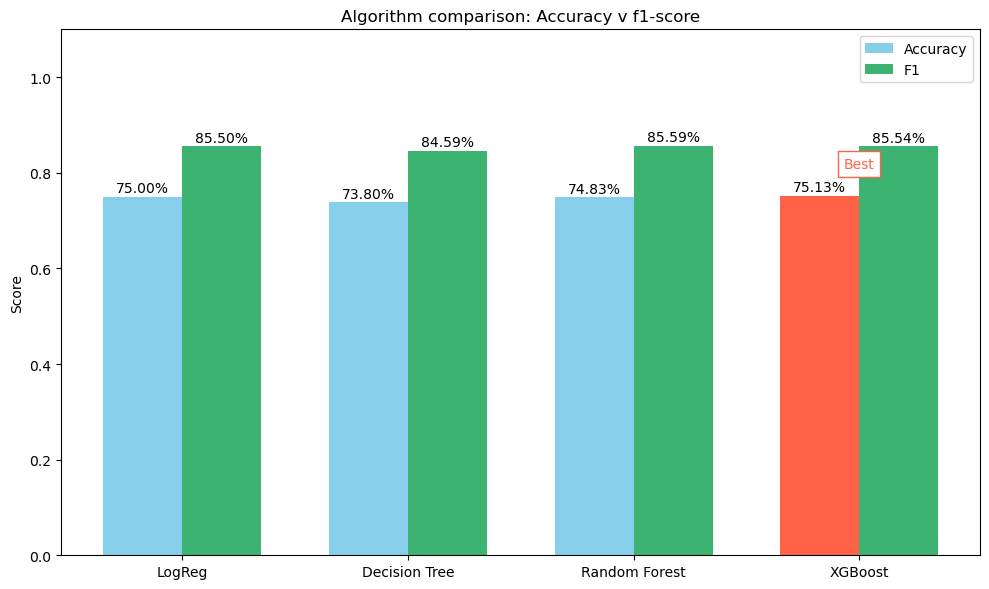

In [25]:
# Quick comparison of how our models did

fig, ax = plt.subplots(figsize=(10, 6))

models = ['LogReg', 'Decision Tree', 'Random Forest', 'XGBoost']
acc = [results[m]['accuracy'] for m in results]
f1 = [results[m]['f1'] for m in results]

x = np.arange(len(models))
bar_width = 0.35

# Basic color styling, highlight best one
highlight = acc.index(max(acc))
acc_colors = ['skyblue' if i != highlight else 'tomato' for i in range(len(models))]

bars_acc = ax.bar(x - bar_width/2, acc, bar_width, label='Accuracy', color=acc_colors)
bars_f1 = ax.bar(x + bar_width/2, f1, bar_width, label='F1', color='mediumseagreen')

# add labels
for bar in bars_acc + bars_f1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{bar.get_height():.2%}", ha='center', fontsize=10)

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_title('Algorithm comparison: Accuracy v f1-score')
ax.set_ylabel('Score')
ax.set_ylim(0, 1.1)
ax.legend()

# mark best
ax.annotate('Best', xy=(highlight, 0.81), ha='center', color='tomato', bbox=dict(facecolor='white', edgecolor='tomato'))

plt.tight_layout()
plt.show()


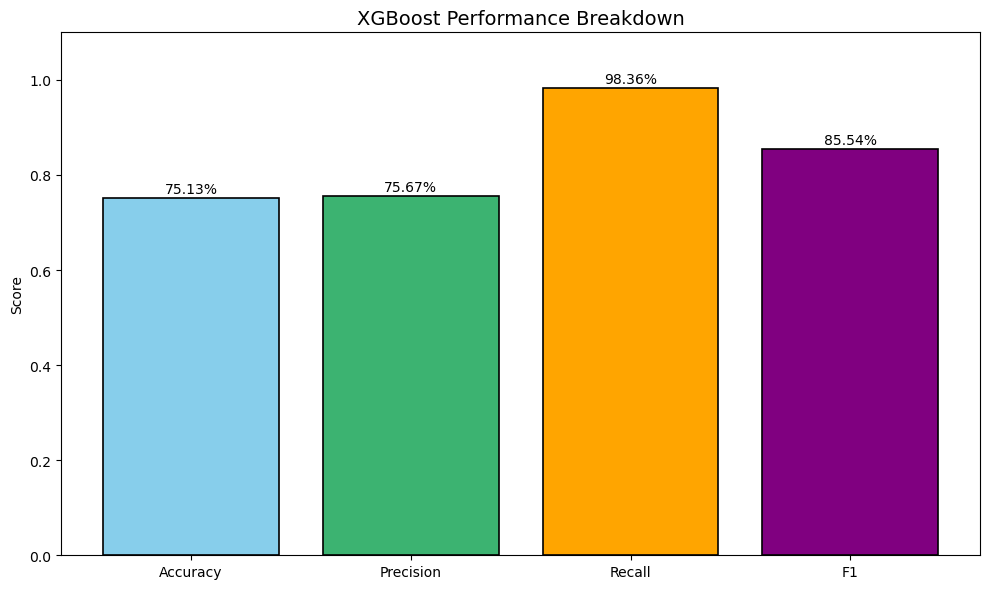

In [26]:
# Quick look at how XGBoost performed across key metrics

xgb = results['XGBoost']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
scores = [xgb['accuracy'], xgb['precision'], xgb['recall'], xgb['f1']]
colors = ['skyblue', 'mediumseagreen', 'orange', 'purple']

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=colors, edgecolor='black', linewidth=1.2)

# add % eprcentage labels on top - from stack overflow
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{score:.2%}", ha="center")

plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("XGBoost Performance Breakdown", fontsize=14)
plt.tight_layout()
plt.show()



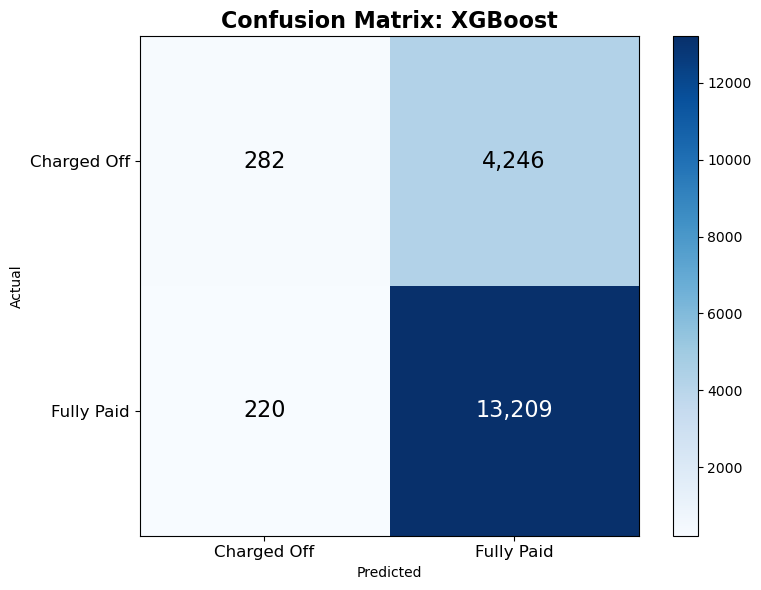


Confusion Matrix Breakdown:
True Negatives (correctly predicted defaults): 282
False Positives (predicted paid, butdefaulted): 4,246
False Negatives (predicted default, but  paid): 220
True Positives (correctly predicted paid loans): 13,209


In [27]:
# Visualising how well XGBoost handled each class (Slide 14)

from sklearn.metrics import confusion_matrix

# Get confusion matrix from validation predictions
cm = confusion_matrix(y_val, xgb['predictions'])

plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix: XGBoost', fontsize=16, fontweight='bold')
plt.colorbar()

# Set axis labels
plt.xticks([0, 1], ['Charged Off', 'Fully Paid'], fontsize=12)
plt.yticks([0, 1], ['Charged Off', 'Fully Paid'], fontsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Annotate each cell with the value
for i in range(2):
    for j in range(2):
        count = cm[i, j]
        color = 'white' if count > cm.max() / 2 else 'black'
        plt.text(j, i, f'{count:,}', ha='center', va='center',
                 fontsize=16, color=color)

plt.tight_layout()
plt.show()

# Print breakdown in the console
print("\nConfusion Matrix Breakdown:")
print(f"True Negatives (correctly predicted defaults): {cm[0, 0]:,}")
print(f"False Positives (predicted paid, butdefaulted): {cm[0, 1]:,}")
print(f"False Negatives (predicted default, but  paid): {cm[1, 0]:,}")
print(f"True Positives (correctly predicted paid loans): {cm[1, 1]:,}")


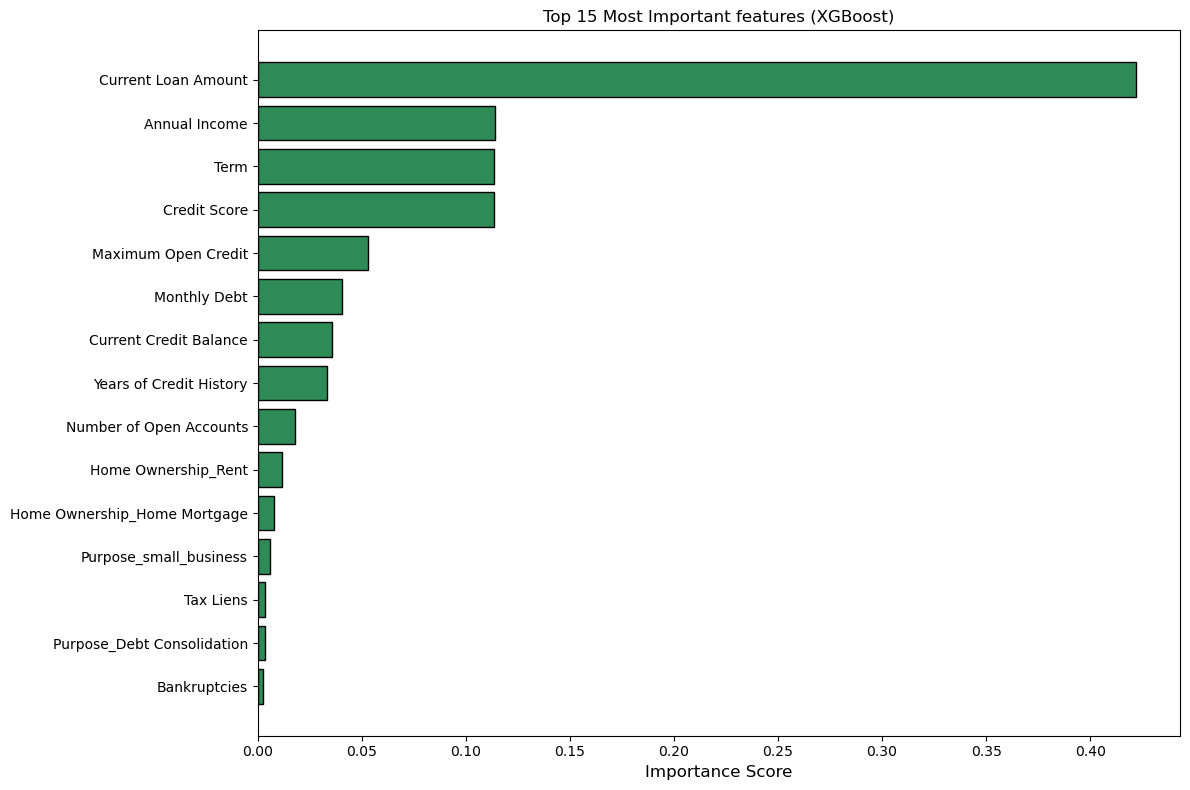


Top 5 Features According to XGBoost:
Current Loan Amount: 0.4220
Annual Income: 0.1141
Term: 0.1138
Credit Score: 0.1134
Maximum Open Credit: 0.0532


In [28]:
# Visualising the most important features used by our XGBoost model (Slide 15)

# Extract the trained model from results
xgb_model = results['XGBoost']['model']

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
})

# Get the top 15 most important features
top_features = feature_importance_df.sort_values(by='Importance', ascending=True).tail(15)

# Plotting the feature importances
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Importance'],
         color='seagreen', edgecolor='black')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 15 Most Important features (XGBoost)')
plt.tight_layout()
plt.show()

# Print out the top 5 in the console to show in console
print("\nTop 5 Features According to XGBoost:")
for i, row in top_features.sort_values(by='Importance', ascending=False).head(5).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")



---
## Section 5: Test Predictions (Slide 16)

Now we apply our trained XGBoost model to the test dataset (10,353 loans) to make predictions. These are loans where we don't know the actual outcome - the model predicts whether each will be Charged Off or Fully Paid.


In [29]:
# Apply XGBoost to test data

print("="*60)
print("TEST PREDICTIONS")
print("="*60)

#xgboost on train data, expecting interesting results
test_pred = xgb_model.predict(X_test_final)
test_labels = le_target.inverse_transform(test_pred)

print(f"Total predictions: {len(test_labels):,}")
print(f"Fully Paid: {sum(test_labels=='Fully Paid'):,} ({sum(test_labels=='Fully Paid')/len(test_labels)*100:.1f}%)")
print(f"Charged Off: {sum(test_labels=='Charged Off'):,} ({sum(test_labels=='Charged Off')/len(test_labels)*100:.1f}%)")

TEST PREDICTIONS
Total predictions: 10,353
Fully Paid: 10,089 (97.5%)
Charged Off: 264 (2.5%)


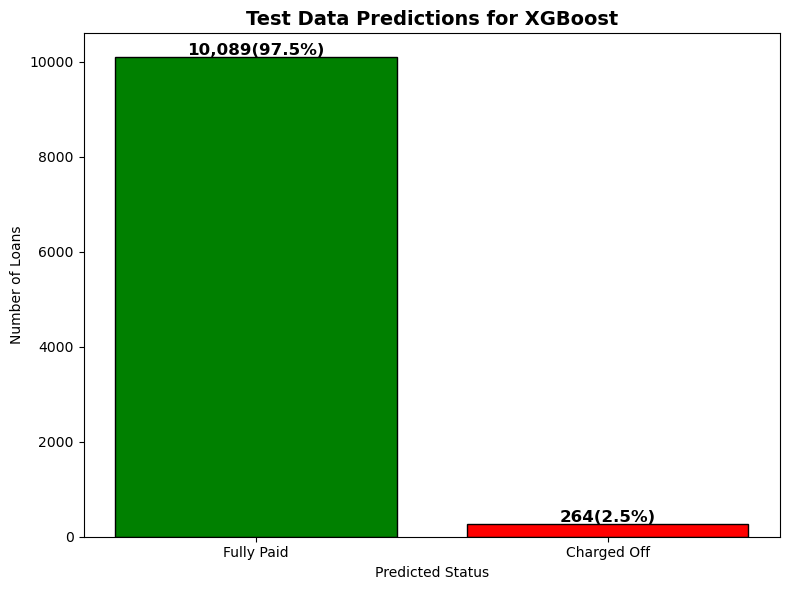

In [30]:
# Test predictions bar chart 

plt.figure(figsize=(8, 6))

counts = pd.Series(test_labels).value_counts()
colors = ['green', "red"]

bars = plt.bar(counts.index, counts.values, color=colors, edgecolor='black')

#display number on bar chart top
for bar, count in zip(bars, counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'{count:,}({count/len(test_labels)*100:.1f}%)', ha='center', fontsize=12, fontweight='bold')
    # +50 just so it just hovers on the bar
plt.ylabel('Number of Loans')
plt.xlabel('Predicted Status')
plt.title('Test Data Predictions for XGBoost', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [31]:
# Save predictions to CSV - not necessary but just in case

output = pd.DataFrame({
    'Loan ID': test_ids,
    'Predicted Status': test_labels
})
print(f"\nFirst 5 predictions:")
print(output.head())


First 5 predictions:
                                Loan ID Predicted Status
0  f738779f-c726-40dc-92cf-689d73af533d       Fully Paid
1  6dcc0947-164d-476c-a1de-3ae7283dde0a       Fully Paid
2  f7744d01-894b-49c3-8777-fc6431a2cff1       Fully Paid
3  83721ffb-b99a-4a0f-aea5-ef472a138b41       Fully Paid
4  08f3789f-5714-4b10-929d-e1527ab5e5a3       Fully Paid


"Once you are happy with the quality of your predictions, you are to apply the trained model to the testing dataset" - Assesement Brief

---
## Section 6: Conclusion (Slide 17)

### Summary
- Tested 4 algorithms: Logistic Regression, Decision Tree, Random Forest, XGBoost
- **XGBoost achieved best results**: 75.19% accuracy, 85.56% F1-Score
- Key features: Current Loan Amount, Credit Score, Annual Income

### Limitations
- Class imbalance (77% vs 23%) - model tends to predict Fully Paid more often
- Missing values required imputation - may have introduced some bias
- Accuracy limited by data quality (outliers, placeholder values)

### Future Work
- Try neural networks (covered in Lectures 17-19)
- Apply SMOTE for class imbalance
- Feature engineering (e.g., debt-to-income ratio)


In [32]:
# Final summary
print("=== FINAL SUMMARY ===\n")

print("Preprocessing:")
print(f"  Started with 100,514 rows, ended with {len(X_train_full):,}")
print(f"  Removed 10,728 duplicates")
print(f"  Final features: {X_train_full.shape[1]}")

print("\nModel Results:")
for name in ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']:
    acc = results[name]['accuracy']*100
    f1 = results[name]['f1']*100
    print(f"  {name}: {acc:.1f}% acc, {f1:.1f}% F1")

print(f"\nBest model: XGBoost")

print(f"\nConfusion Matrix:")
print(f"  TN={cm[0][0]}, FP={cm[0][1]}, FN={cm[1][0]}, TP={cm[1][1]}")

print(f"\nTest predictions: {sum(test_labels=='Fully Paid')} Fully Paid, {sum(test_labels=='Charged Off')} Charged Off")


=== FINAL SUMMARY ===

Preprocessing:
  Started with 100,514 rows, ended with 89,785
  Removed 10,728 duplicates
  Final features: 40

Model Results:
  Logistic Regression: 75.0% acc, 85.5% F1
  Decision Tree: 73.8% acc, 84.6% F1
  Random Forest: 74.8% acc, 85.6% F1
  XGBoost: 75.1% acc, 85.5% F1

Best model: XGBoost

Confusion Matrix:
  TN=282, FP=4246, FN=220, TP=13209

Test predictions: 10089 Fully Paid, 264 Charged Off


NOTE: there may be small deviations in project values vs presentaiton values due to random seed variations in train/test splits